In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer


import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/epileptic/Epileptic_Seizure_Recognition.csv")
data = data.drop(columns=['Unnamed'])
data.loc[data["y"] > 1 , "y"] = 0
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [4]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data = data[:70000]

In [5]:
target = 'y'

In [6]:
X = data.drop(columns=[target])
y = data[target]

In [7]:
#model_ctgan = CTGANSynthesizer(epochs=50)
#model_ctgan = DPCTGANSynthesizer(verbose=True)
model_ctgan = FPGANSynthesizer(epochs=25, verbose=True)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data, rate=0.25)

Epoch 1, Loss G: -0.4493,Loss D: -4.1055
Epoch 2, Loss G: -0.6230,Loss D: -0.4736
Epoch 3, Loss G: -0.4308,Loss D:  0.0455
Epoch 4, Loss G: -0.0470,Loss D:  0.3810
Epoch 5, Loss G: -0.1770,Loss D: -1.3470
Epoch 6, Loss G: -0.4324,Loss D:  0.8982
Epoch 7, Loss G: -0.2871,Loss D: -1.6182
Epoch 8, Loss G: -0.4803,Loss D: -0.6371
Epoch 9, Loss G: -0.3699,Loss D:  0.2453
Epoch 10, Loss G: -0.2442,Loss D: -0.8349
Epoch 11, Loss G: -0.2903,Loss D: -0.2844
Epoch 12, Loss G: -0.2465,Loss D: -0.8160
Epoch 13, Loss G: -0.0941,Loss D: -0.8008
Epoch 14, Loss G: -0.1233,Loss D: -3.5523
Epoch 15, Loss G: -0.2209,Loss D: -2.5080
Epoch 16, Loss G: -0.2128,Loss D: -3.6557
Epoch 17, Loss G: -0.2222,Loss D: -5.5764
Epoch 18, Loss G: -0.2437,Loss D: -4.7894
Epoch 19, Loss G: -0.2489,Loss D: -5.4146
Epoch 20, Loss G: -0.2312,Loss D: -7.9959
Epoch 21, Loss G: -0.4296,Loss D: -2.9115
Epoch 22, Loss G: -0.3064,Loss D: -1.7846
Epoch 23, Loss G: -0.4206,Loss D: -2.0097
Epoch 24, Loss G: -0.3887,Loss D: -0.5129
E

([array(0.04444131, dtype=float32),
  array(0.11997064, dtype=float32),
  array(0.2350178, dtype=float32),
  array(0.3475485, dtype=float32),
  array(0.45855185, dtype=float32),
  array(0.6099642, dtype=float32),
  array(0.7153106, dtype=float32),
  array(0.81839377, dtype=float32),
  array(0.95713633, dtype=float32),
  array(1.0246446, dtype=float32),
  array(1.2029217, dtype=float32),
  array(1.1473254, dtype=float32),
  array(1.1350644, dtype=float32),
  array(1.0813534, dtype=float32),
  array(1.032771, dtype=float32),
  array(0.83199805, dtype=float32),
  array(0.58668613, dtype=float32),
  array(0.42044723, dtype=float32),
  array(0.0655931, dtype=float32),
  array(-0.09726831, dtype=float32),
  array(-0.29394728, dtype=float32),
  array(-0.5605222, dtype=float32),
  array(-0.7338729, dtype=float32),
  array(-0.80913657, dtype=float32),
  array(-1.0616696, dtype=float32),
  array(-1.2559853, dtype=float32),
  array(-1.4318475, dtype=float32),
  array(-1.5372565, dtype=float32),
 

In [8]:
from utils.utils import save_models
save_models(model_ctgan, '025fpgan25', 'epileptic')

In [9]:
from utils.utils import load_models
model_ctgan = load_models('025fpgan25', 'epileptic')

In [19]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [20]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [21]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.06705789]


## Fidelity

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test, undersample = True)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test, undersample = True)

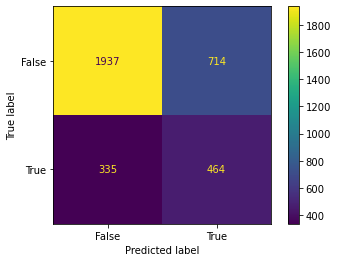

In [23]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [24]:
percentage = eval_fidelity(rr_pred, fr_pred)

In [25]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.9208695652173913
Accuracy of synthetic data:  0.696231884057971


In [26]:
from utils.fidelity import get_roc_auc

rr_score = get_roc_auc(y_test, rr_pred)
fr_score = get_roc_auc(y_test, fr_pred)
print("ROC AUC of real data: ", rr_score)
print("ROC AUC of synthetic data: ", fr_score)

ROC AUC of real data:  0.9059782608695653
ROC AUC of synthetic data:  0.6579710144927536


## Final plot

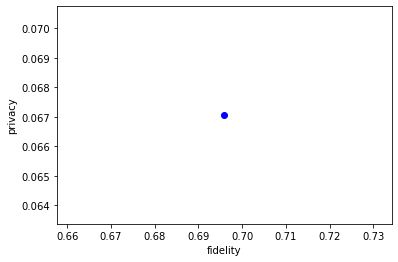

0.6959420289855073 [0.06705789]


In [27]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)